## Pipeline de Modelo para Fashion MNIST de Arboles de Decision

#### Importación de bibliotecas y carga de datos  

Se importan las bibliotecas numpy para manipulación numérica, scikit-learn para aprendizaje automático, y keras para cargar el dataset. El conjunto de datos Fashion MNIST consta de 60,000 imágenes de entrenamiento y 10,000 de prueba, cada una representando una prenda de vestir en escala de grises de 28x28 píxeles. La elección de este dataset es relevante porque, a diferencia del MNIST clásico (dígitos escritos a mano), introduce mayor complejidad al incluir categorías más diversas y sutiles, lo que permite evaluar mejor el rendimiento del modelo en tareas desafiantes.

#### Preprocesamiento de los datos  

Aplanamiento de imágenes : Las imágenes se convierten de matrices 2D (28x28) a vectores 1D (784 elementos) mediante reshape. Esto es necesario porque los modelos de scikit-learn, como el árbol de decisión, requieren entradas en formato tabular (filas = muestras, columnas = características).

Normalización : Los valores de píxeles se escalan al rango [0, 1] dividiendo entre 255. Este paso es crucial para acelerar el entrenamiento y evitar sesgos hacia características con valores absolutos mayores.

#### Validación cruzada inicial  

Se instancia un DecisionTreeClassifier con una semilla aleatoria fija (27369180) para garantizar reproducibilidad. Luego, se aplica validación cruzada con 5 folds  para estimar el rendimiento del modelo sin ajustar hiperparámetros. La media y desviación estándar de las precisiones obtenidas (ej. 0.82 ± 0.01) ofrecen una idea de la estabilidad del modelo. Este paso sirve como línea base para comparar mejoras posteriores.

#### Búsqueda de hiperparámetros con GridSearchCV  

Se define un conjunto de hiperparámetros para explorar combinaciones que maximicen la precisión:

max_depth : Controla la profundidad máxima del árbol. Valores altos pueden causar sobreajuste, mientras que valores bajos subajuste.
min_samples_split  y min_samples_leaf : Establecen umbrales mínimos de muestras para permitir divisiones o definir hojas, respectivamente. Valores altos reducen la complejidad del modelo.
max_features : Limita el número de características consideradas en cada división. Opciones como sqrt o log2 introducen regularización.
criterion : Define la función para medir la calidad de una división (gini o entropy). Aunque su impacto suele ser moderado, se incluye para exhaustividad.

Se utiliza GridSearchCV con validación cruzada de 3 folds  para reducir el costo computacional.

#### Evaluación final y resultados  

Tras encontrar los mejores hiperparámetros, se entrena el modelo óptimo y se evalúa en el conjunto de test. La precisión en el test refleja el rendimiento en datos no vistos durante el entrenamiento. La diferencia entre la precisión en validación cruzada y en el test indica si el modelo generaliza adecuadamente con los mejores hiperparametros encontrados por gridsearch. Si el rendimiento con los mejores hiperparametros encontrados es inferior a la validacion cruzada sin estos, podría requerirse una nueva busqueda para encontrar hiperparametros diferentes que mejoren el rendimiento del modelo.

In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score

# Cargamos dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# Aplanamos las imagenes
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalizamos los valores
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Hacemos la validacion cruzada sin parametros
Modelo = DecisionTreeClassifier(random_state=27369180)
validaciones = cross_val_score(Modelo, X_train, y_train, cv=5, scoring='accuracy')
print(f"Precisión con validación cruzada (5 folds): {validaciones.mean():.4f} ± {validaciones.std():.4f}")

# Definimos parametros para gridsearch
parametros = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Buscamos los hiperparametros
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=27369180),
    param_grid=parametros,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Mostramos los resultados
print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
print(f"Precisión en validación cruzada: {grid_search.best_score_:.4f}")

# Evaluamos con el dataset de test
Modelo = grid_search.best_estimator_
y_pred = Modelo.predict(X_test)
precision = accuracy_score(y_test, y_pred)
print(f"\nPrecisión en conjunto de test: {precision:.4f}")

Precisión con validación cruzada (5 folds): 0.7952 ± 0.0029

Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Precisión en validación cruzada: 0.8099

Precisión en conjunto de test: 0.8124


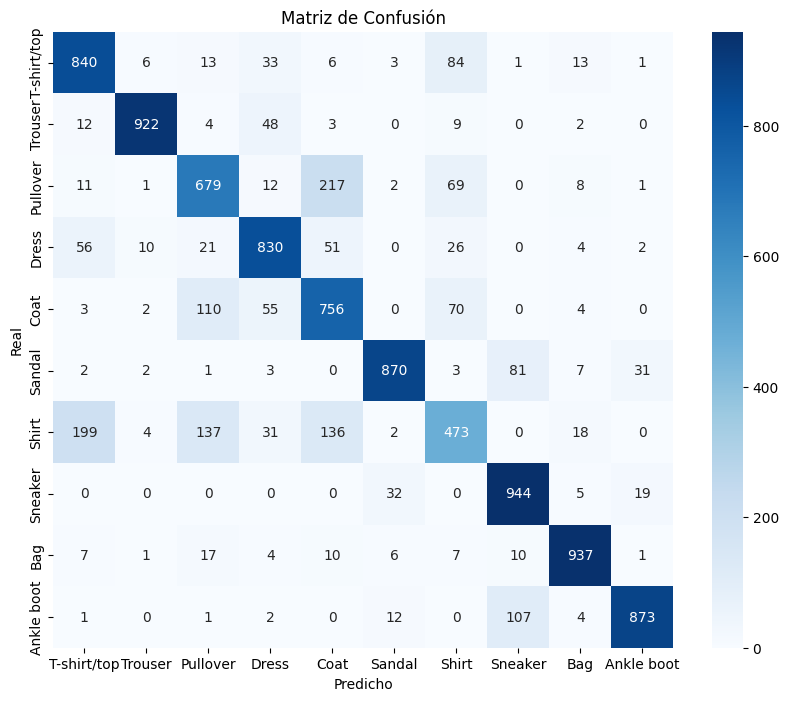

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

# Definimos las etiquetas de Fashion MNIST
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Matriz de Confusión
matriz = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [7]:
# Reporte de Clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=labels))

Reporte de Clasificación:
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.84      0.79      1000
     Trouser       0.97      0.92      0.95      1000
    Pullover       0.69      0.68      0.68      1000
       Dress       0.82      0.83      0.82      1000
        Coat       0.64      0.76      0.69      1000
      Sandal       0.94      0.87      0.90      1000
       Shirt       0.64      0.47      0.54      1000
     Sneaker       0.83      0.94      0.88      1000
         Bag       0.94      0.94      0.94      1000
  Ankle boot       0.94      0.87      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



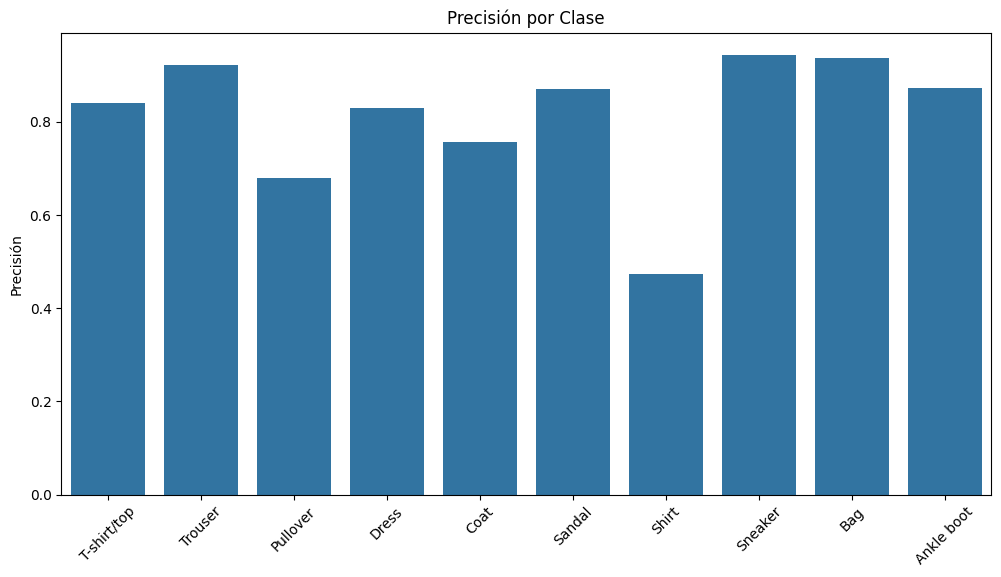

In [8]:
# Precisión por Clase
precision = {}
for i in np.unique(y_test):
    indice = np.where(y_test == i)
    precision[labels[i]] = accuracy_score(y_test[indice], y_pred[indice])

# Graficamos precisión por clase
plt.figure(figsize=(12, 6))
sns.barplot(x=list(precision.keys()), y=list(precision.values()))
plt.xticks(rotation=45)
plt.title('Precisión por Clase')
plt.ylabel('Precisión')
plt.show()